In [194]:
"""
Train a classifier on top of a language model trained with `pretrain_lm.py`.
Optionally fine-tune LM before.
"""
import numpy as np
import pickle

import torch
import torch.nn.functional as F
from fastai.text import TextLMDataBunch, TextClasDataBunch, language_model_learner, text_classifier_learner, LanguageLearner
from fastai import fit_one_cycle
from fastai_contrib.utils import PAD, UNK, read_clas_data, PAD_TOKEN_ID, DATASETS, TRN, VAL, TST, ensure_paths_exists, get_sentencepiece
from fastai.text.transform import Vocab
from fastai.metrics import accuracy, accuracy_thresh, fbeta

import fire
from collections import Counter
from pathlib import Path

import pandas as pd
import csv
from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2

# NTCIR-13 MedWeb
http://research.nii.ac.jp/ntcir/permission/ntcir-13/perm-ja-MedWeb.html

## copy data

In [3]:
!ls /home/ubuntu/dev/download/data/MedWeb_TestCollection/

NTCIR-13_MedWeb_en_test.xlsx	  NTCIR-13_MedWeb_ja_training.xlsx  readme.txt
NTCIR-13_MedWeb_en_training.xlsx  NTCIR-13_MedWeb_zh_test.xlsx
NTCIR-13_MedWeb_ja_test.xlsx	  NTCIR-13_MedWeb_zh_training.xlsx


In [4]:
!cat /home/ubuntu/dev/download/data/MedWeb_TestCollection/readme.txt

NTCIR-13 MedWeb task: Test set

Training data
-MedWeb Japanese subtask train data: NTCIR-13_MedWeb_ja_training.xlsx
-MedWeb English subtask train data: NTCIR-13_MedWeb_en_training.xlsx
-MedWeb Chinese subtask train data: NTCIR-13_MedWeb_zh_training.xlsx

Test data
-MedWeb Japanese subtask test data: NTCIR-13_MedWeb_ja_test.xlsx
-MedWeb English subtask test data: NTCIR-13_MedWeb_en_test.xlsx
-MedWeb Chinese subtask test data: NTCIR-13_MedWeb_zh_test.xlsx


Columns in each sheet are as follows. 
ID: Pseudo tweet ID that corresponds to the corpora of other language (e.g., the tweet of ``1en'' corresponds to the tweets of ``1ja'' and ``1zh'') 
Tweet: Pseudo tweet message 
Influenza: P (Positive) / N (Negative)
Diarrhea: P (Positive) / N (Negative)
Hayfever: P (Positive) / N (Negative)
Cough: P (Positive) / N (Negative)
Headache: P (Positive) / N (Negative)
Fever: P (Positive) / N (Negative)
Runnynose: P (Positive) / N (Negative)
Cold: P (Positive) / N (Negative)

For details, please refer 

In [5]:
!mkdir -p data/MedWeb

In [6]:
!cp /home/ubuntu/dev/download/data/MedWeb_TestCollection/*ja* data/MedWeb/

In [7]:
!ls data/MedWeb/

lbl_names.pkl		      NTCIR-13_MedWeb_ja_training.xlsx	train.csv
NTCIR-13_MedWeb_ja_test.xlsx  tmp				valid.csv


## read data

### train

In [8]:
trn = pd.read_excel('data/MedWeb/NTCIR-13_MedWeb_ja_training.xlsx',sheet_name='ja_train')

In [9]:
trn.head(100)

,ID,Tweet,Influenza,Diarrhea,Hayfever,Cough,Headache,Fever,Runnynose,Cold
0,1ja,風邪を引くと全身がだるくなる。,n,n,n,n,n,n,n,p
1,2ja,花粉症の症状が出てきたのは久し振りだ。,n,n,p,n,n,n,p,n
2,3ja,花粉症のせいでずっと微熱でぼーっとしてる。眠い。,n,n,p,n,n,p,p,n
3,4ja,薬飲んだけど鼻水おさまる気配なし,n,n,n,n,n,n,p,n
4,5ja,ネパールに旅行に行った際に下痢になって大変だったよ。,n,n,n,n,n,n,n,n
5,6ja,咳くらいで休むのはゆとりだけだろ。どんなときでも仕事にでるのは大事だ。,n,n,n,p,n,n,n,n
6,7ja,鼻づまりで今日は休むわー,n,n,n,n,n,n,p,n
7,8ja,まさか花粉症になるとは。,n,n,p,n,n,n,p,n
8,9ja,熱は出てるけどお腹に来る風邪じゃなさそう。,n,n,n,n,n,p,n,p
9,10ja,痰に血が混じってきもい,n,n,n,p,n,n,n,n


In [10]:
# name of labels
lbl_names = trn.columns[2:]
lbl_names

Index(['Influenza', 'Diarrhea', 'Hayfever', 'Cough', 'Headache', 'Fever',
       'Runnynose', 'Cold'],
      dtype='object')

In [11]:
# save
pickle.dump(lbl_names, open('data/MedWeb/lbl_names.pkl','wb'))

3列目以降がpの列名を列挙して、ラベルとする

trn_lbl = ['_'.join(row) for row in ((trn.iloc[:,2:] == 'p')*1).values.astype(str)]

trn_lbl = [','.join(row) for row in trn.columns[2:] + '_' +trn.iloc[:,2:]]

for i, row in trn.iterrows():
    print(','.join(lbl_names[row[2:]=='p']))
    if i > 5:
        break

In [12]:
lbl_idx = np.asarray([i for i in range(len(lbl_names))])

In [13]:
lbl_idx

array([0, 1, 2, 3, 4, 5, 6, 7])

In [14]:
trn_lbl = []
for i, row in trn.iterrows():
    trn_lbl.append(lbl_idx[(row[2:]=='p').values])

In [15]:
trn_lbl[:5]

[array([7]),
 array([2, 6]),
 array([2, 5, 6]),
 array([6]),
 array([], dtype=int64)]

In [16]:
# put data into df and save
trn_df = pd.DataFrame({'text':trn['Tweet'].values, 'labels':trn_lbl},columns=['labels', 'text'])
trn_df.to_csv('data/MedWeb/train.csv', header=False, index=False)


In [17]:
trn_df

,labels,text
0,[7],風邪を引くと全身がだるくなる。
1,"[2, 6]",花粉症の症状が出てきたのは久し振りだ。
2,"[2, 5, 6]",花粉症のせいでずっと微熱でぼーっとしてる。眠い。
3,[6],薬飲んだけど鼻水おさまる気配なし
4,[],ネパールに旅行に行った際に下痢になって大変だったよ。
5,[3],咳くらいで休むのはゆとりだけだろ。どんなときでも仕事にでるのは大事だ。
6,[6],鼻づまりで今日は休むわー
7,"[2, 6]",まさか花粉症になるとは。
8,"[5, 7]",熱は出てるけどお腹に来る風邪じゃなさそう。
9,[3],痰に血が混じってきもい


### test

In [18]:
tst = pd.read_excel('data/MedWeb/NTCIR-13_MedWeb_ja_test.xlsx',sheet_name='ja_test')

In [19]:
tst.head(100)

,ID,Tweet,Influenza,Diarrhea,Hayfever,Cough,Headache,Fever,Runnynose,Cold
0,1921ja,旅行に行ったら、土産にインフルもらってきた。,p,n,n,n,n,p,n,n
1,1922ja,きつい上司、頭痛の種,n,n,n,n,n,n,n,n
2,1923ja,もう誰か翻訳してくれないときつい、宇宙の言葉ですかってくらい通じなくて頭痛してきた。,n,n,n,n,n,n,n,n
3,1924ja,インフル感染の危機。,p,n,n,n,n,p,n,n
4,1925ja,鼻づまりがひどいからスピーチは無理だ,n,n,n,n,n,n,p,n
5,1926ja,頭痛がしているので帰ることにする。,n,n,n,n,p,n,n,n
6,1927ja,インフルエンザになって部活のみんなから爆笑されたよ,p,n,n,n,n,p,n,n
7,1928ja,下痢って英語でなんていうんだろう。,n,n,n,n,n,n,n,n
8,1929ja,スペイン風邪、香港風邪っていうけど、日本風邪ってあるの？,n,n,n,n,n,n,n,n
9,1930ja,犬って鼻づまりとかするのかな？,n,n,n,n,n,n,n,n


In [20]:
tst_lbl = []
for i, row in tst.iterrows():
    tst_lbl.append(lbl_idx[(row[2:]=='p').values])

In [21]:
tst_lbl[:5]

[array([0, 5]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([0, 5]),
 array([6])]

In [22]:
# name of labels
lbl_names = tst.columns[2:]
lbl_names

Index(['Influenza', 'Diarrhea', 'Hayfever', 'Cough', 'Headache', 'Fever',
       'Runnynose', 'Cold'],
      dtype='object')

In [23]:
# put data into df and save
tst_df = pd.DataFrame({'text':tst['Tweet'].values, 'labels':tst_lbl},columns=['labels', 'text'])
# change name from test to valid (fastai lm expects valid)
tst_df.to_csv('data/MedWeb/valid.csv', header=False, index=False)


In [24]:
tst_df.head()

,labels,text
0,"[0, 5]",旅行に行ったら、土産にインフルもらってきた。
1,[],きつい上司、頭痛の種
2,[],もう誰か翻訳してくれないときつい、宇宙の言葉ですかってくらい通じなくて頭痛してきた。
3,"[0, 5]",インフル感染の危機。
4,[6],鼻づまりがひどいからスピーチは無理だ


## prepare data for lm fine tuning and classification
basically copying from train_cls.py

In [25]:
data_dir='data'
lang='ja' 
cuda_id=0 
pretrain_name='wt-100' 
model_dir='data/wiki/ja-100/models'
qrnn=True
fine_tune=True 
max_vocab=16000
bs=20 
bptt=70 
name='MedWeb-clas'
dataset='MedWeb' 
ds_pct=1.0
spm_dir = 'data/wiki/ja/'

In [26]:
results={}
if not torch.cuda.is_available():
    print('CUDA not available. Setting device=-1.')
    cuda_id = -1
torch.cuda.set_device(cuda_id)

print(f'Dataset: {dataset}. Language: {lang}.')

Dataset: MedWeb. Language: ja.


In [27]:
data_dir = Path(data_dir)
assert data_dir.name == 'data',\
    f'Error: Name of data directory should be data, not {data_dir.name}.'
dataset_dir = data_dir / dataset
model_dir = Path(model_dir)


if qrnn:
    print('Using QRNNs...')
model_name = 'qrnn' if qrnn else 'lstm'
lm_name = f'{model_name}_{pretrain_name}'
pretrained_fname = (lm_name, f'itos_{pretrain_name}')

ensure_paths_exists(data_dir,
                    dataset_dir,
                    model_dir,
                    model_dir/f"{pretrained_fname[0]}.pth",
                    model_dir/f"{pretrained_fname[1]}.pkl")


tmp_dir = dataset_dir / 'tmp'
tmp_dir.mkdir(exist_ok=True)
vocab_file = tmp_dir / f'vocab_{lang}.pkl'

Using QRNNs...


In [28]:
# here we're just loading the trained spm model
sp = get_sentencepiece(spm_dir, None, 'wt-all', vocab_size=max_vocab)

In [29]:
# load train, valid in df
train_df = pd.read_csv(dataset_dir/'train.csv',header=None)
valid_df = pd.read_csv(dataset_dir/'valid.csv',header=None)

In [30]:
train_df.head()

,0,1
0,[7],風邪を引くと全身がだるくなる。
1,[2 6],花粉症の症状が出てきたのは久し振りだ。
2,[2 5 6],花粉症のせいでずっと微熱でぼーっとしてる。眠い。
3,[6],薬飲んだけど鼻水おさまる気配なし
4,[],ネパールに旅行に行った際に下痢になって大変だったよ。


In [31]:
def strip_brackets(s):
    return s.strip('[]')

In [32]:
train_df[0] = train_df[0].apply(strip_brackets)

In [33]:
valid_df[0] = valid_df[0].apply(strip_brackets)

In [34]:
list(csv.reader(train_df.loc[1,0]))

[['2'], [' '], ['6']]

### lm data

In [35]:
# set label_delim for multilabel (MultiCategory) data
data_lm = TextLMDataBunch.from_df(path=dataset_dir,train_df=train_df,valid_df=valid_df,label_delim=' ',**sp)

In [36]:
data_lm

TextLMDataBunch;
Train: LabelList
y: LMLabel (1920 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/MedWeb
x: LMTextList (1920 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 風 邪 を 引 く と 全身 が だ る くなる 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の 症状 が出 てきた の は 久 し 振り だ 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の せい で ずっと 微 熱 で ぼ ー っ として る 。 眠 い 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 薬 飲 んだ けど 鼻 水 おさ まる 気 配 なし, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ネパール に 旅行 に 行った 際に 下 <unk> になって 大変 だった よ 。]...
Path: data/MedWeb;
Valid: LabelList
y: LMLabel (640 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/MedWeb
x: LMTextList (640 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅行 に 行った ら 、 土 産 に イン フル も ら ってきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ き つ い 上 司 、 頭 痛 の 種, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ もう 誰か 翻訳 して く れない とき つ い 、 宇宙 の言葉 です か って くらい 通じ なく て 頭 痛 してきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ イン フル 感染 の 危機 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 鼻 

### classification data

In [37]:
# set label_delim for multilabel (MultiCategory) data
data_clas = TextClasDataBunch.from_df(path=dataset_dir,train_df=train_df,valid_df=valid_df,label_delim=' ',**sp)

In [38]:
data_clas

TextClasDataBunch;
Train: LabelList
y: MultiCategoryList (1920 items)
[MultiCategory 7, MultiCategory 2;6, MultiCategory 2;5;6, MultiCategory 6, MultiCategory ]...
Path: data/MedWeb
x: TextList (1920 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 風 邪 を 引 く と 全身 が だ る くなる 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の 症状 が出 てきた の は 久 し 振り だ 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の せい で ずっと 微 熱 で ぼ ー っ として る 。 眠 い 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 薬 飲 んだ けど 鼻 水 おさ まる 気 配 なし, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ネパール に 旅行 に 行った 際に 下 <unk> になって 大変 だった よ 。]...
Path: data/MedWeb;
Valid: LabelList
y: MultiCategoryList (640 items)
[MultiCategory 0;5, MultiCategory , MultiCategory , MultiCategory 0;5, MultiCategory 6]...
Path: data/MedWeb
x: TextList (640 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅行 に 行った ら 、 土 産 に イン フル も ら ってきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ き つ い 上 司 、 頭 痛 の 種, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ もう 誰か 翻訳 して く れない とき つ い 、 宇宙 の言葉 です か って くらい 通じ なく て 頭 痛 してきた 。, Text ▁ x x b

In [215]:
data_clas.valid_ds.x.get(100)

Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 熱 が 出て リン パ が 腫 れた

In [216]:
data_clas.valid_ds.y.get(100)

MultiCategory 5

## fine tune lm

In [39]:
if qrnn:
    emb_sz, nh, nl = 400, 1550, 3
else:
    emb_sz, nh, nl = 400, 1150, 3

In [195]:
learn = language_model_learner(
    data_lm, bptt=bptt, emb_sz=emb_sz, nh=nh, nl=nl, qrnn=qrnn,
    pad_token=PAD_TOKEN_ID,
    pretrained_fnames=pretrained_fname,
    path=model_dir.parent, model_dir=model_dir.name)
lm_enc_finetuned  = f"{lm_name}_{dataset}_enc"

In [196]:
learn

LanguageLearner(data=TextLMDataBunch;
Train: LabelList
y: LMLabel (1920 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/MedWeb
x: LMTextList (1920 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 風 邪 を 引 く と 全身 が だ る くなる 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の 症状 が出 てきた の は 久 し 振り だ 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の せい で ずっと 微 熱 で ぼ ー っ として る 。 眠 い 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 薬 飲 んだ けど 鼻 水 おさ まる 気 配 なし, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ネパール に 旅行 に 行った 際に 下 <unk> になって 大変 だった よ 。]...
Path: data/MedWeb;
Valid: LabelList
y: LMLabel (640 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/MedWeb
x: LMTextList (640 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅行 に 行った ら 、 土 産 に イン フル も ら ってきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ き つ い 上 司 、 頭 痛 の 種, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ もう 誰か 翻訳 して く れない とき つ い 、 宇宙 の言葉 です か って くらい 通じ なく て 頭 痛 してきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ イン フル 感染 の 危機 。, Text ▁ x x bo s

In [199]:
lm = LanguageLearner(data_lm,learn.model)

In [203]:
lm.predict('料金が高い', n_words=200)

Total time: 00:08



'料金が高い 場合は ある 車は ダ から 経歴 荒川 の 多数の 各 ウェブサイト と対戦 する 」 昆 湖 設置 テキスト である が 来 の高い 「 ▁ ご じ ま 作品 風の 奇襲 と よ づ れ ており 、 vi me cr s 。 高齢 に 答え 刊行 という 設備 警察 四 足 の パ 生産 に 引っ 返 らせ と 大 タ の ハン ・ ストラ テ を用いた 国鉄 、 クロ ヴィ sp old 初頭 も 追 走 回目 が開始され て に 押し 出 ていない ことがある 。 ▁ ▁ ト フランス語 先輩 引き 継ぎ 高校 といい 、 ▁ 物を 計 み 仮名 強盗 発 ダイ ハ ハ エイト ( 情報 の ニ からは のか 高額 泉 ・ ▁ ・ フィリピン から 公国 が 、 関連 の 当時 ト と ▁ ん ぶつ 荷 重 山 アイ アキ レ の 大部分が 一 今まで 進んで きた という アイ ホ プ ビング か フリー ト ・ シーズン 普通 学習 コース の 承諾 ( 事例 を受け 単位 の特徴 から 、 エーカー ア ヴェー ト アイ ザクセン で 「 ▁ 「 経 率 生産 ヒン フィン を含む 後に それらの ( 井 プロダクション は 「 2 , ▁1991 年 、 ブラジル 、 1800 系 となって 投 部門 のため'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


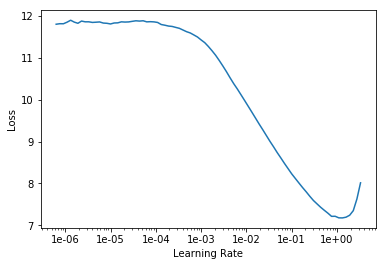

In [117]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [122]:
if fine_tune:
    print('Fine-tuning the language model...')
    learn.unfreeze()
    learn.fit(10, slice(1e-3, 1e-1))

    # save encoder
    learn.save_encoder(lm_enc_finetuned)

Total time: 00:08
epoch  train_loss  valid_loss  accuracy
1      3.142347    2.767759    0.557026  (00:00)
2      2.960647    2.711176    0.565997  (00:00)
3      2.872180    2.635541    0.573352  (00:00)
4      2.796479    2.600125    0.576489  (00:00)
5      2.721043    2.558426    0.585552  (00:00)
6      2.656562    2.521225    0.590956  (00:00)
7      2.607434    2.495195    0.599054  (00:00)
8      2.583707    2.496899    0.596627  (00:00)
9      2.532210    2.458076    0.603136  (00:00)
10     2.486725    2.433290    0.607190  (00:00)



## create classifier

In [123]:
# change metric from accuracy to accuarcy_thresh
thresh = 0.5
sigmoid = False
accuracy_multi =  partial(accuracy_thresh,thresh=thresh,sigmoid=sigmoid)

In [124]:
beta = 1
f1 = partial(fbeta,thresh=thresh,beta=beta,sigmoid=sigmoid)

In [125]:
model_dir

PosixPath('data/wiki/ja-100/models')

In [126]:
print("Starting classifier training")
learn = text_classifier_learner(data_clas, bptt=bptt, pad_token=PAD_TOKEN_ID,
                              path=model_dir.parent, model_dir=model_dir.name,
                              qrnn=qrnn, emb_sz=emb_sz, nh=nh, nl=nl)

learn.load_encoder(lm_enc_finetuned)

# change metric to something that supports multilabel
# https://forums.fast.ai/t/a-quick-and-easy-way-to-make-ulmfit-work-for-multi-label-problems/17222/20
learn.metrics = [accuracy_multi,f1]
# learn.metrics = [accuracy_thresh]

Starting classifier training


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


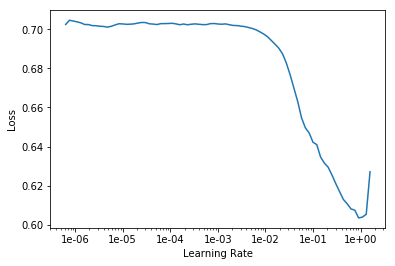

In [129]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


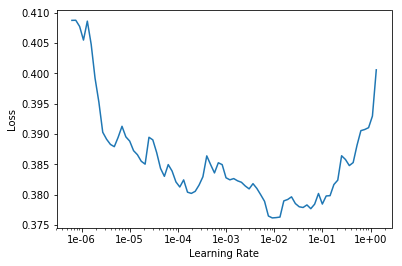

In [130]:
learn.fit_one_cycle(1, 5e-1, moms=(0.8, 0.7), wd=1e-7)
learn.freeze_to(-2)

learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


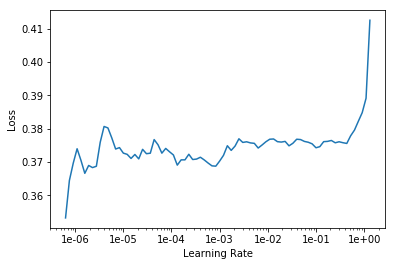

In [131]:
lr = 1e-2
learn.fit_one_cycle(1, slice(lr / (2.6 ** 4), lr), moms=(0.8, 0.7), wd=1e-7)
learn.freeze_to(-3)

learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


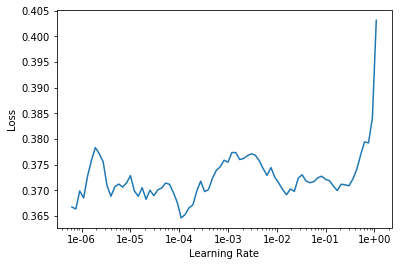

In [132]:
lr = 1e-3
learn.fit_one_cycle(1, slice(lr/ (2.6 ** 4), lr), moms=(0.8, 0.7), wd=1e-7)
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [133]:
lr = 1e-4
learn.fit_one_cycle(2, slice(lr / (2.6 ** 4), lr), moms=(0.8, 0.7), wd=1e-7)
results['accuracy_multi'] = learn.validate()[1]
results['F1'] = learn.validate()[2]

In [134]:
learn.validate()

[0.3552218, tensor(0.8826), tensor(0.0004)]

In [135]:
results

{'accuracy_multi': tensor(0.8826), 'F1': tensor(0.0004)}

In [136]:
learn.metrics

[functools.partial(<function accuracy_thresh at 0x7f0318f7ad90>, thresh=0.5, sigmoid=False),
 functools.partial(<function fbeta at 0x7f0318f7ad08>, thresh=0.5, beta=1, sigmoid=False)]

In [164]:
learn.model.named_parameters

<bound method Module.named_parameters of SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(16000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(16000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=800, out_features=4650, bias=True)
        )
      )
      (1): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1550, out_features=4650, bias=True)
        )
      )
      (2): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1550, out_features=1200, bias=True)
        )
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1)

In [138]:
learn.loss_func

<function torch.nn.functional.binary_cross_entropy_with_logits(input, target, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)>

In [179]:
F.binary_cross_entropy??

In [182]:
preds=learn.get_preds()

In [183]:
preds

[tensor([[0.0484, 0.0927, 0.0965,  ..., 0.1741, 0.1977, 0.1216],
         [0.0498, 0.0882, 0.0956,  ..., 0.1739, 0.1976, 0.1202],
         [0.0472, 0.0869, 0.0976,  ..., 0.1709, 0.2003, 0.1226],
         ...,
         [0.0487, 0.0940, 0.0990,  ..., 0.1694, 0.1953, 0.1249],
         [0.0484, 0.0911, 0.0998,  ..., 0.1684, 0.1950, 0.1234],
         [0.0498, 0.0885, 0.0945,  ..., 0.1739, 0.1966, 0.1242]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 1., 0., 0.]])]

In [192]:
preds[1][:,-2].mean()

tensor(0.1922)

In [188]:
p=preds[0]

In [189]:
p.shape

torch.Size([640, 8])

In [175]:
p = p.tolist()

In [178]:
np.asarray(p).sum(axis=1)

array([0.959545, 0.959206, 0.959052, 0.957988, ..., 0.957122, 0.959946, 0.961164, 0.962246])

In [143]:
p[:2]

[[0.04835744947195053,
  0.09274126589298248,
  0.09653706103563309,
  0.12112784385681152,
  0.11122231930494308,
  0.17412583529949188,
  0.1977453976869583,
  0.12161774188280106],
 [0.04977883771061897,
  0.0881970077753067,
  0.09561492502689362,
  0.12042585760354996,
  0.11564001441001892,
  0.1738794893026352,
  0.19760961830615997,
  0.1202014908194542]]

In [144]:
p = np.asarray(p)

In [145]:
p.sum(axis=1)

array([0.963475, 0.961347, 0.959819, 0.963932, ..., 0.964786, 0.958969, 0.955669, 0.962694])

In [146]:
data_clas.valid_ds.y.items

array([list([0, 5]), list([]), list([]), list([0, 5]), ..., list([3, 5, 7]), list([1]), list([]), list([5])],
      dtype=object)

In [147]:
t = data_clas.valid_ds.y.items
t = pd.Series(t)

In [148]:
t.shape

(640,)

In [149]:
t.head()

0    [0, 5]
1        []
2        []
3    [0, 5]
4       [6]
dtype: object

In [150]:
t_dumb = np.zeros([t.shape[0], len(p[0])])
for i, row in t.iteritems():
    for y in row:
        t_dumb[i][y] = 1

In [151]:
t_dumb[:2]

array([[1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [166]:
t_dumb.sum()

597.0

In [191]:
t_dumb[:,-2].mean()

0.1921875

In [167]:
t_dumb.sum(axis=1).max()

4.0

In [152]:
p_01 = (p>=0.5)*1.0
p_01[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [153]:
p.sum()

619.2492797691375

In [155]:
p_01.sum()

6.0

In [65]:
print(f"Saving models at {learn.path / learn.model_dir}")
learn.save(f'{model_name}_{name}')

Saving models at data/wiki/ja-100/models


In [66]:
print(results)

{'accuracy_multi': tensor(0.8834), 'F1': tensor(0.)}
